In [1]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

입력값

In [2]:
x = 40 # 가입나이
m = 20 # 납입기간
n = 60 # 보험기간
w = 110 # 한계연령
ctr = 1 # 계약종별 코드
m_prime = 12 # 납입주기

ir = 0.025 # 이자율
v = 1/(1+ir)

l0 = 100000
l0_prime = 100000
K = 100000 # 가입금액

위험율

In [3]:
risk = pd.read_csv('전립선암.csv', header = None)
# risk.head()

In [4]:
age = risk.iloc[:, 0].values
risk_rate = risk.iloc[:, 1].values

In [5]:
inter = interp1d(age, risk_rate, kind = 'linear')

In [6]:
# 위험율
q_x = inter(range(w+1))
q_prime_x = inter(range(w+1))

기본 세팅

In [7]:
df = {}
df['x+t'] = range(x, w)
df['q_x+t'] = q_x[x:w]
df["q'_x+t"] = q_prime_x[x:w]
df = pd.DataFrame(df)
df.index = df.index.set_names(['t'])
# df.head()

해지율

    1종 : 무해지
    2종 : 일반

In [8]:
if ctr==1:
    df['w_x+t'] = [0.04]*m + [0]*(df.shape[0]-m)
else:
    df['w_x+t'] = [0]*(df.shape[0])
# df.head()

,x+t,q_x+t,q'_x+t,w_x+t
t,,,,
65,105,0.003448,0.003448,0.0
66,106,0.003448,0.003448,0.0
67,107,0.003448,0.003448,0.0
68,108,0.003448,0.003448,0.0
69,109,0.003448,0.003448,0.0


$ l_{x+1} = l_x * (1-q_x) * (1-w_x)$

$ l_x = l^{'}_x $

In [9]:
l_x, l_prime_x = [l0], [l0_prime]

for t in range(w-x-1):
    l_before, l_prime_before = l_x[t], l_prime_x[t]
    l_next = l_before * (1-df['q_x+t'].values[t]) * (1-df['w_x+t'].values[t])
    l_prime_next = l_prime_x[t] * (1-df['q_x+t'].values[t]) * (1-df['w_x+t'].values[t]/2)
    l_x.append(l_next)
    l_prime_x.append(l_prime_next)

df['l_x+t'] = l_x
df["l'_x+t"] = l_prime_x
# df.head()

$D_x = l_x * v^x$

$C_x = d_x * v^x$

$ N_x = D_x + D_{x+1} + D_{x+2} +....$

$ M_x = C_x + C_{x+1} + C_{x+2} +....$

In [10]:
df['D_x+t'] = df['l_x+t'] * v**df.index.values
df['C_x+t'] = df['l_x+t'] * df['q_x+t'] * v**df.index.values
df['N_x+t'] = [sum(df['D_x+t'].loc[t:]) for t in range(df.shape[0])]
df['M_x+t'] = [sum(df['C_x+t'].loc[t:]) for t in range(df.shape[0])]
# df.head()

$D^{'}_x = l^{'}_x * v^x$

$C^{'}_x = d^{'}_x * v^x$

$ N^{'}_x = D^{'}_x + D^{'}_{x+1} + D^{'}_{x+2} +....$

$ M^{'}_x = C^{'}_x + C^{'}_{x+1} + C^{'}_{x+2} +....$

In [12]:
df["D'_x+t"] = df["l'_x+t"] * v**df.index.values
df["C'_x+t"] = df["l'_x+t"] * df["q'_x+t"] * v**df.index.values
df["N'_x+t"] = [sum(df["D'_x+t"].loc[t:]) for t in range(df.shape[0])]
df["M'_x+t"] = [sum(df["C'_x+t"].loc[t:]) for t in range(df.shape[0])]
# df.head()

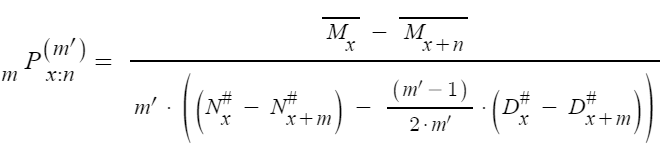

In [13]:
net_prenium_nominator = df['M_x+t'].values[0] - df['M_x+t'].values[n]
net_prenium_denominator = m_prime * ((df["N'_x+t"].values[0] - df["N'_x+t"].values[m]) - 
                                     (m_prime-1)/(2*m_prime) * (df["D'_x+t"].values[0] - df["D'_x+t"].values[m]))
net_prenium = net_prenium_nominator / net_prenium_denominator
print(f'순보험료 : {net_prenium}')
print(f'가입금액 곱한 값 : {int(K*net_prenium)}')

순보험료 : 0.00014304188549884152
가입금액 곱한 값 : 14
